In [145]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### What is PCA?
Principle component analysis is an unsupervised, non-parametric, linear dimensionality reduction technique. 
### Why is it important?
PCA reduces dimensionality while maintaining as much informative variance as possible.
1. remove redundancy by eliminating correlated features
2. improve interpretability
3. enhance computational efficiency
### What should we know to use PCA?
PCA relies on several key assumptions:
1. linearity in data
2. variance as information, assuming noise has a lower variance
3. orthogonal basis: the principle components are independent

In [151]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)

In [152]:
X = iris.data.to_numpy()
y = iris.target.to_numpy()

In [97]:
def PCA_eigenvalue(M, n_components=2):
    """
    Calculate principal components with eigenvectors of covariance matrix
    Params:
        M(np.array): original matrix
    Returns:
        M_reduced(np.array): reduced M
    """
    # centralized M
    feature_mean = M.mean(axis=0)
    M_centered = M - feature_mean
    
    # calculate covariance matrix
    covariance_matrix = np.cov(M_centered, rowvar=False)
    
    # calculate eigenvectors matrix
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # sort eigenvalues
    sorted_indices = np.argsort(eigenvalues)[::-1]

    # rearrange eigenvalues and eigenvector with sorted_indices
    # making them sort with the magnitude of eigenvalues
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # get n_components principal components
    principal_components = eigenvectors[:, :n_components]
    explained_variance_ratio = eigenvalues[:n_components] / np.sum(eigenvalues)
    
    # calulate reduced M
    M_reduced = M @ principal_components

    return(M_reduced, explained_variance_ratio, principal_components.T)
    # in sklearn default, principal components is presented in row
    
    

    
    

In [98]:
X_reduced_eigen, explained_variance_ratio_eigen, principal_components_eigen = PCA_eigenvalue(X)

In [71]:
explained_variance_ratio_eigen
# The first and second PC captures 92% and 5% of the variance in the data set.

array([0.92461872, 0.05306648])

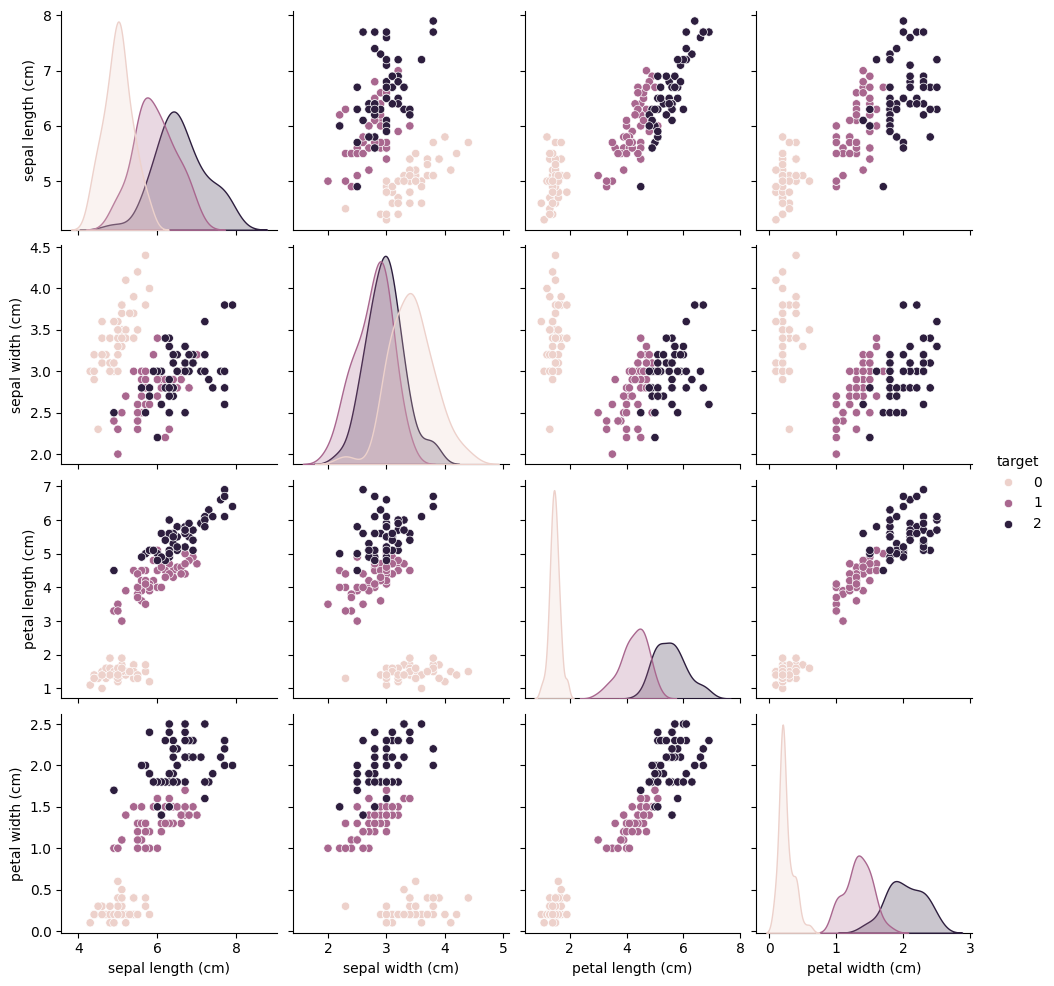

In [61]:
sns.pairplot(iris.frame, hue="target")

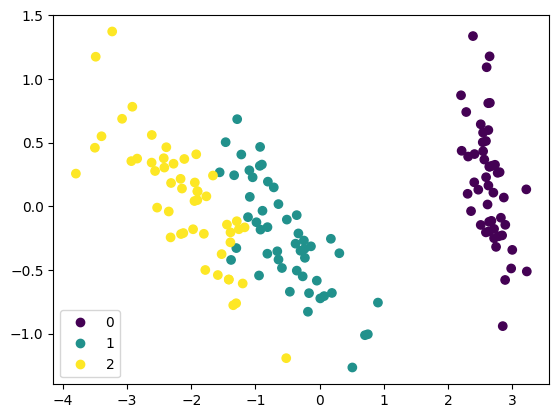

In [72]:
scatter = plt.scatter(X_reduced_eigen[:,0], X_reduced_eigen[:,1], c=y)
plt.legend(*scatter.legend_elements())

In [95]:
def PCA_SVD(M, n_components=2):
    """
    Calculate principal components with singular value decomposition
    Params:
        M(np.array): original matrix
    Returns:
        M_reduced(np.array): reduced M
    """
    # centralized M
    feature_mean = M.mean(axis=0)
    M_centered = M - feature_mean
    
    # calculate svd decomposition
    U, S, Vt = np.linalg.svd(M_centered, full_matrices=False)
    
    # explain vairiance
    explained_variance = (S**2) / (X.shape[0] - 1)
    explained_variance_ratio = explained_variance / np.sum(explained_variance)

    # pc
    principal_components = Vt[:n_components, :]
    # flip the principal component to make it same as EVD
    for i in range(principal_components.shape[0]):
        principal_components[i, :] *= -1
        
    
    # calulate reduced M
    M_reduced = M @ principal_components.T

    return(M_reduced, explained_variance_ratio, principal_components)
    
    

    
    

In [96]:
X_reduced_svd, explained_variance_ratio_svd, principal_components_svd = PCA_SVD(X)

In [93]:
explained_variance_ratio_svd

array([0.92461872, 0.05306648, 0.01710261, 0.00521218])

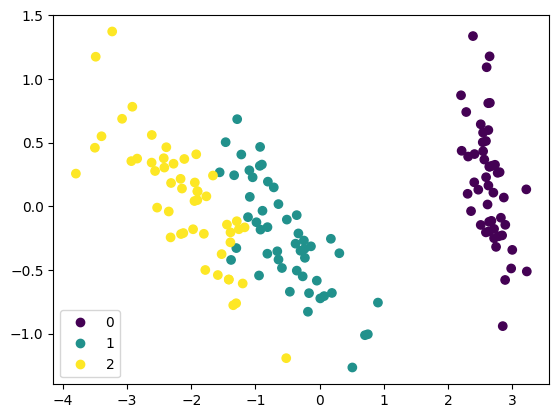

In [87]:
scatter = plt.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=y)
plt.legend(*scatter.legend_elements())

### How to find oridinal features importance based on PC?

In [99]:
principal_components_svd

array([[-0.36138659,  0.08452251, -0.85667061, -0.3582892 ],
       [ 0.65658877,  0.73016143, -0.17337266, -0.07548102]])

In [100]:
principal_components_eigen

array([[-0.36138659,  0.08452251, -0.85667061, -0.3582892 ],
       [ 0.65658877,  0.73016143, -0.17337266, -0.07548102]])

In [140]:
def original_basis_to_pc(M, principal_components_svd):
    # get original basis
    features_size = M.shape[1]
    original_basis = np.eye(features_size)

    # 
    original_basis_in_pca = principal_components_svd @ original_basis

    return(original_basis_in_pca)
    

In [141]:
original_basis_in_pca = original_basis_to_pc(X, principal_components_svd)

In [142]:
original_basis_in_pca

array([[-0.36138659,  0.08452251, -0.85667061, -0.3582892 ],
       [ 0.65658877,  0.73016143, -0.17337266, -0.07548102]])

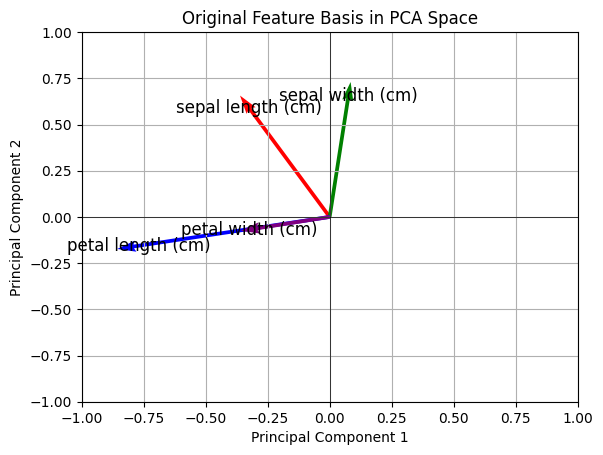

In [143]:
# plt.figure(figsize=(6, 6))
origin = np.zeros((2, 4))  # Start points for quiver plot

# Plot principal component axes
plt.quiver(origin[0], origin[1], original_basis_in_pca[0], original_basis_in_pca[1], scale=1,
           angles='xy', scale_units='xy', color=['r', 'g', 'b', 'purple'])

# Adjust labels dynamically within the bounds
plt.xlim(-1, 1)
plt.ylim(-1, 1)

# Labels
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Original Feature Basis in PCA Space")
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(True)

# Annotate feature names near the tip but slightly inside
feature_names = iris.feature_names
for i in range(4):
    plt.text(original_basis_in_pca[0, i] * 0.9, original_basis_in_pca[1, i] * 0.9, 
             feature_names[i], fontsize=12, ha='center', va='center', color='black')

As seen in the figure, petal width and petal length are strongly aligned with Principal Component 1 (PC1), which explains 92% of the variance in the dataset. This suggests that these two features contribute the most to the primary variability in the data, making them more important for distinguishing patterns compared to the other two features (sepal width and sepal length).

We can also see petal width and petal length aligned together, which indicates they are highly correlated. We can verify with the following code:

In [157]:
print(iris.feature_names)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [156]:
pd.DataFrame(X[:, 2:4]).corr()

,0,1
0,1.000000,0.962865
1,0.962865,1.000000
